# Data Preparation

In [11]:
import numpy as np
import pandas as pd

df =  pd.read_csv('results.csv')

In [14]:
df["date"] = pd.to_datetime(df["date"])

df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [15]:
df.dropna(inplace=True)

In [17]:
df.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

Dataset yang digunakan adalah FIFA Games antara 2018, dari setelah Piala Dunia 2018 hingga pertandingan terakhir sebelum Piala Dunia 2022. Idenya adalah untuk menganalisis hanya permainan yang dimainkan saat persiapan dan klasifikasi ke WC.

In [18]:
df.sort_values("date").tail()
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)

In [19]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
3926,2022-12-14,France,Morocco,2,0,FIFA World Cup,Al Khor,Qatar,True
3929,2022-12-14,Vietnam,Philippines,1,0,Friendly,Hanoi,Vietnam,False
3931,2022-12-17,Singapore,Maldives,3,1,Friendly,Singapore,Singapore,False
3930,2022-12-17,Croatia,Morocco,2,1,FIFA World Cup,Al Rayyan,Qatar,True
3932,2022-12-18,Argentina,France,3,3,FIFA World Cup,Lusail,Qatar,True


In [20]:
df.home_team.value_counts()

United States    46
Qatar            43
Mexico           43
Japan            42
Bahrain          39
                 ..
Chameria          1
Székely Land      1
Catalonia         1
Cascadia          1
Orkney            1
Name: home_team, Length: 247, dtype: int64

In [21]:
rank = pd.read_csv("fifa_ranking-2022-10-06.csv")

In [22]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)

Beberapa tim di Piala Dunia memiliki nama berbeda di dataset peringkat. Jadi, perlu penyesuaian.

In [24]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

Penggabungan ini dilakukan untuk mendapatkan dataset game FIFA dan rankingnya.

In [25]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [26]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [27]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
2530,2021-11-11,Brazil,Colombia,1,0,FIFA World Cup qualification,São Paulo,Brazil,False,1820.36,1811.73,2.0,0.0,1618.76,1618.40,16.0,0.0
2631,2021-11-16,Argentina,Brazil,0,0,FIFA World Cup qualification,San Juan,Argentina,False,1738.79,1725.31,6.0,0.0,1820.36,1811.73,2.0,0.0
2739,2022-01-27,Ecuador,Brazil,1,1,FIFA World Cup qualification,Quito,Ecuador,False,1448.27,1448.74,46.0,0.0,1826.35,1826.35,2.0,0.0
2772,2022-02-01,Brazil,Paraguay,4,0,FIFA World Cup qualification,Belo Horizonte,Brazil,False,1826.35,1826.35,2.0,0.0,1454.52,1454.52,43.0,0.0
2813,2022-03-24,Brazil,Chile,4,0,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,1823.42,1826.35,2.0,0.0,1543.16,1543.42,26.0,2.0
2896,2022-03-29,Bolivia,Brazil,0,4,FIFA World Cup qualification,La Paz,Bolivia,False,1308.12,1324.21,76.0,-1.0,1823.42,1826.35,2.0,0.0
2988,2022-06-02,South Korea,Brazil,1,5,Friendly,Seoul,South Korea,False,1519.54,1522.85,29.0,0.0,1832.69,1823.42,1.0,-1.0
3056,2022-06-06,Japan,Brazil,0,1,Friendly,Tokyo,Japan,False,1553.44,1549.82,23.0,0.0,1832.69,1823.42,1.0,-1.0
3234,2022-09-23,Brazil,Ghana,3,0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1393.47,1389.68,60.0,0.0
3303,2022-09-27,Brazil,Tunisia,5,1,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1507.86,1507.86,30.0,0.0


Sekarang, kami memiliki data yang siap untuk membuat fitur berdasarkan hasil pertandingan dan peringkat FIFA.

# Mengatur Fitur (Features)

Idenya di sini adalah untuk membuat kemungkinan fitur yang berdampak pada prediksi pertandingan sepak bola. Secara intuisi, kami mengatakan bahwa fitur yang berdampak dapat berupa:

-- Poin permainan sebelumnya dibuat

-- Gol masa lalu dicetak dan kebobolan

-- Pentingnya permainan (bersahabat atau tidak)

-- Peringkat tim

-- Peningkatan peringkat tim

-- Gol dibuat dan diderita oleh peringkat yang dihadapi

Jadi, hal pertama yang harus dilakukan adalah membuat fitur yang menyatakan tim mana yang menang dan berapa banyak poin yang mereka peroleh dalam permainan.

In [28]:
df = df_wc_ranked

def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [29]:
df[["result", "home_team_points", "away_team_points"]] = results

Poin permainan adalah 3 untuk menang, 1 untuk seri dan 0 untuk kalah dan berbeda dengan poin peringkat FIFA yang sudah ada di database. Selain itu, seharusnya poin Peringkat FIFA dan Peringkat FIFA dari tim yang sama berkorelasi negatif, dan kita hanya boleh menggunakan salah satunya untuk membuat fitur baru. 

Sekarang, kami membuat kolom yang akan membantu pembuatan fitur: perbedaan peringkat, poin yang dimenangkan pada pertandingan vs. peringkat tim yang dihadapi, dan perbedaan gol dalam permainan. Semua fitur yang bukan perbedaan harus dibuat untuk kedua tim (tandang dan kandang).

In [30]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [31]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [32]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [33]:
team_stats = home_team.append(away_team)#.sort_values("date")

C:\Users\Efendy Wiranatha\AppData\Local\Temp\ipykernel_23504\275322566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)#.sort_values("date")


In [34]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Sekarang, kami memiliki database yang siap untuk membuat fitur prediktif yaitu:


Rata-rata gol tim dalam Siklus Piala Dunia.

Rata-rata gol tim dalam 5 pertandingan terakhir.

Gol rata-rata diderita tim dalam Siklus Piala Dunia.

Gol rata-rata diderita tim dalam 5 pertandingan terakhir.

Peringkat FIFA rata-rata yang dihadapi tim dalam Siklus Piala Dunia.

Peringkat FIFA rata-rata yang dihadapi tim dalam 5 pertandingan terakhir.

Poin FIFA dimenangkan dalam siklus.

Poin FIFA menang dalam 5 pertandingan terakhir.

Berarti poin permainan di Siklus.

Rata-rata poin permainan pada 5 pertandingan terakhir.

Rata-rata poin permainan berdasarkan peringkat yang dihadapi di Siklus.

Rata-rata poin permainan berdasarkan peringkat yang dihadapi pada 5 pertandingan terakhir.

In [35]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [36]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [37]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

The new columns:

In [38]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [39]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [40]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Untuk menyatukan database, diperlukan sufiks home and away untuk setiap kolom. Setelah itu, data siap untuk digabungkan.

In [41]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [42]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [43]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Now, to quantify game importance, is created a column that finds competition of the game.

Sekarang, untuk mengukur kepentingan game, dibuat kolom yang menemukan persaingan game tersebut.

In [45]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [46]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [47]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Dan, setelah itu, kami hanya memilih kolom yang akan membantu dalam analisis Fitur.

In [48]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
3334,2022-09-27,Norway,Serbia,36.0,25.0,0,2,1,11.0,0.0,...,1.833333,2.0,0.041984,0.090235,1.866667,2.0,0.053327,0.073887,1,0
3335,2022-09-27,Sweden,Slovenia,20.0,65.0,1,1,2,-45.0,0.0,...,1.607843,0.6,0.048520,0.009231,1.404762,1.0,0.026035,0.029545,1,0
3336,2022-09-27,Kosovo,Cyprus,106.0,108.0,5,1,0,-2.0,0.0,...,1.326087,1.2,0.018478,0.016825,0.767442,1.0,0.009687,0.019652,1,0
3337,2022-09-27,Greece,Northern Ireland,49.0,58.0,3,1,0,-9.0,1.0,...,1.590909,2.4,0.050090,0.028040,1.139535,1.0,0.022315,0.009470,1,0
3338,2022-09-30,Fiji,Solomon Islands,163.0,137.0,1,0,0,26.0,0.0,...,1.500000,1.4,0.009432,0.008868,1.714286,2.0,0.010013,0.012387,1,0


In [49]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  101
home_goals_mean_l5               101
home_goals_suf_mean              101
home_goals_suf_mean_l5           101
home_rank_mean                   101
home_rank_mean_l5                101
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

Game dengan NA adalah yang berarti tidak bisa dihitung (game dari awal dataset). Itu akan dihapuskan.

In [50]:
base_df_no_fg = base_df.dropna()

# Analisis Data

Sekarang, kita perlu menganalisis semua fitur yang dibuat dan memeriksa apakah fitur tersebut memiliki kekuatan prediksi. Juga, jika mereka tidak memilikinya, kami perlu membuat beberapa yang memilikinya, seperti perbedaan tim kandang dan tandang. Untuk menganalisis kekuatan prediktif, saya akan menetapkan permainan imbang sebagai kekalahan tim tuan rumah dan akan membuat masalah biner.

In [52]:
df = base_df_no_fg

def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\Efendy Wiranatha\AppData\Local\Temp\ipykernel_23504\1284309440.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


Violin and boxplot untuk menganalisis apakah fitur memiliki distribusi yang berbeda sesuai target, sedangkan
Scatter Plot untuk menganalisis korelasi

In [53]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [54]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

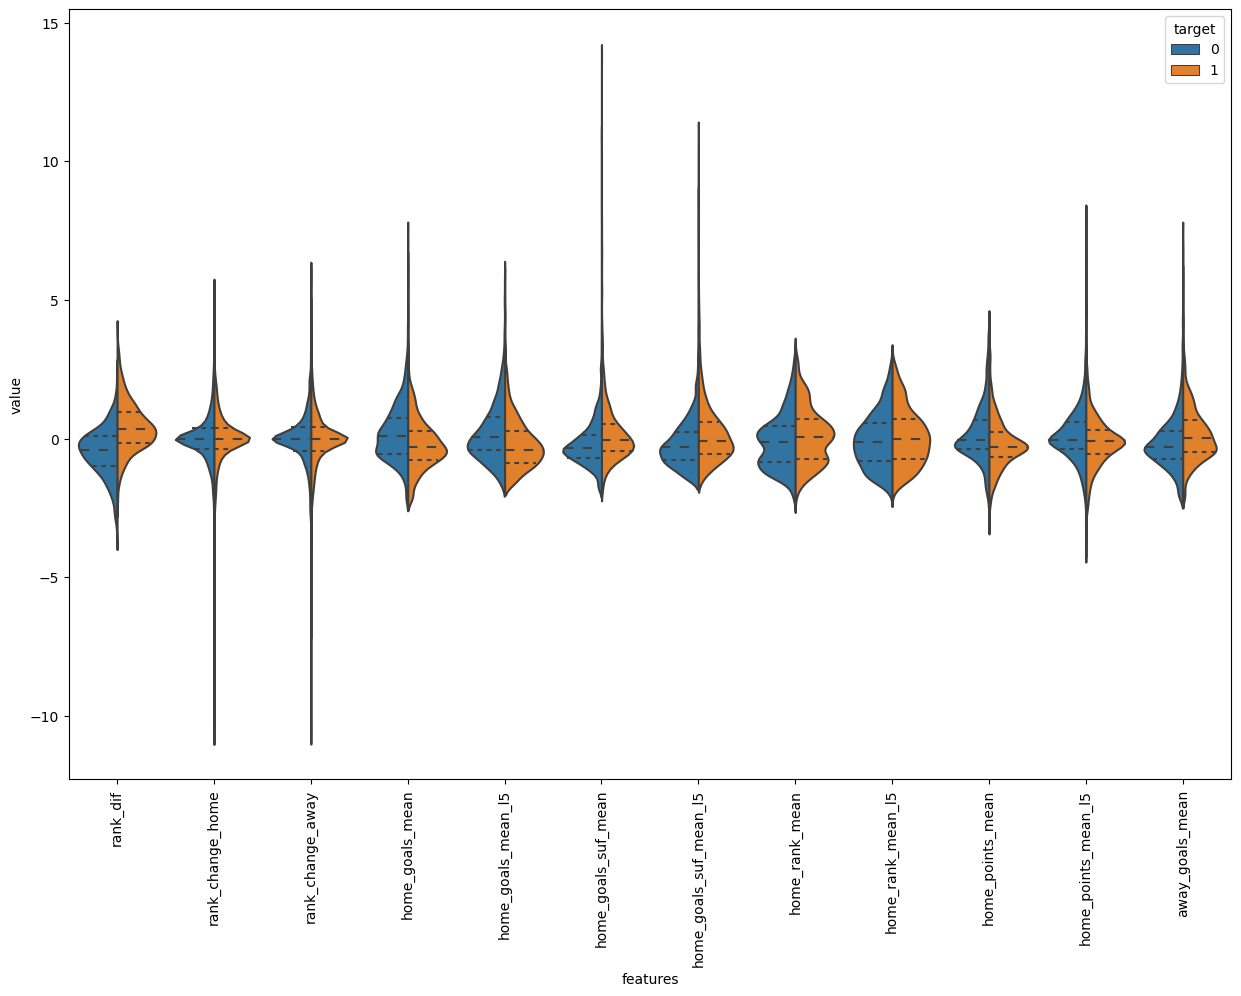

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

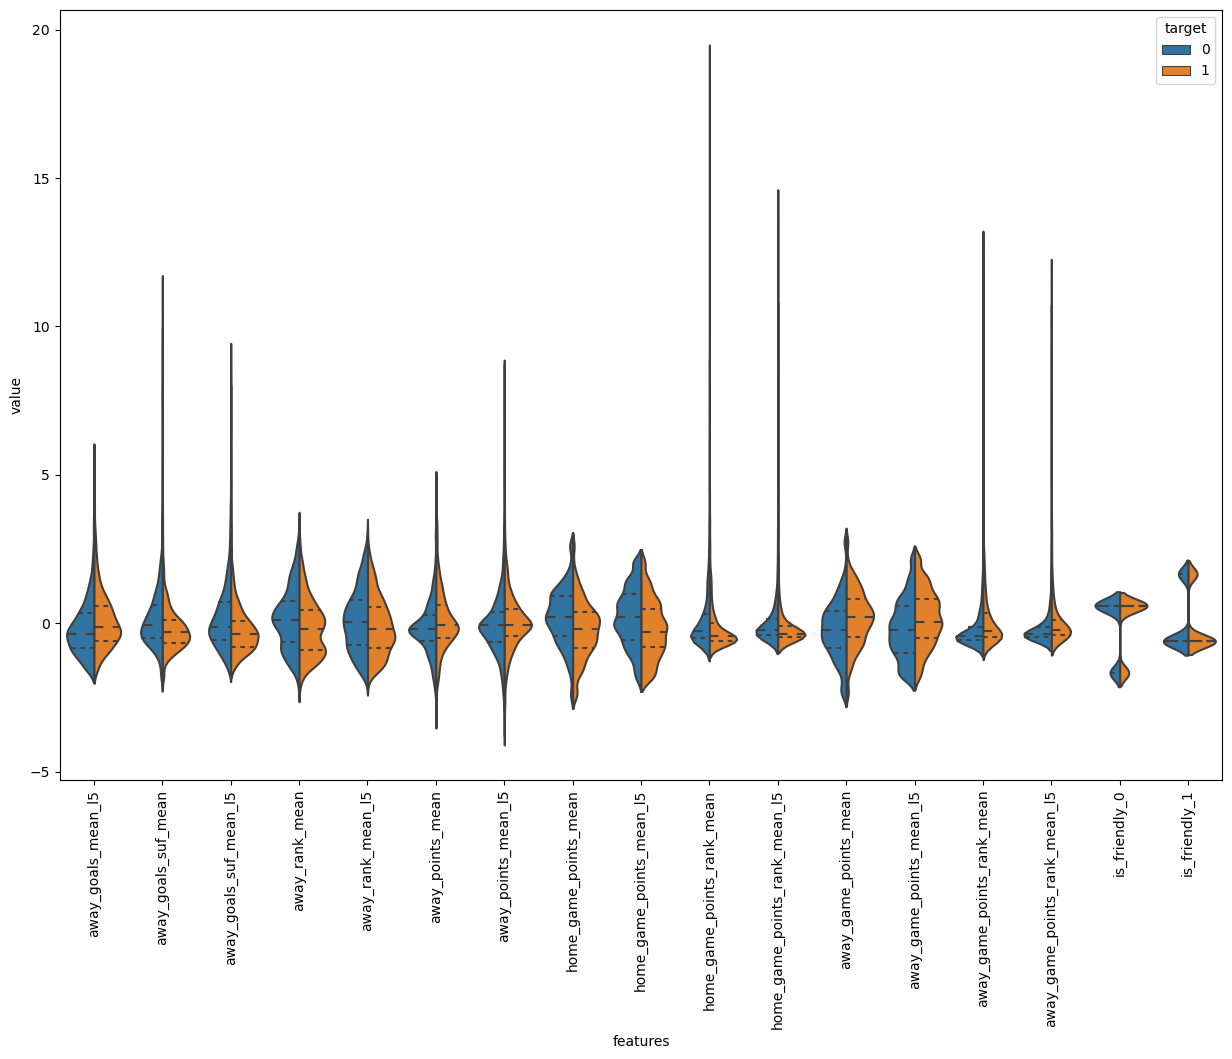

In [57]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Dengan plot, kami menemukan bahwa perbedaan peringkat adalah satu-satunya pemisah data yang baik. Tapi, kita bisa membuat fitur yang mendapatkan perbedaan antara tim tuan rumah dan tandang dan menganalisis apakah mereka memisahkan data dengan baik.

In [58]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

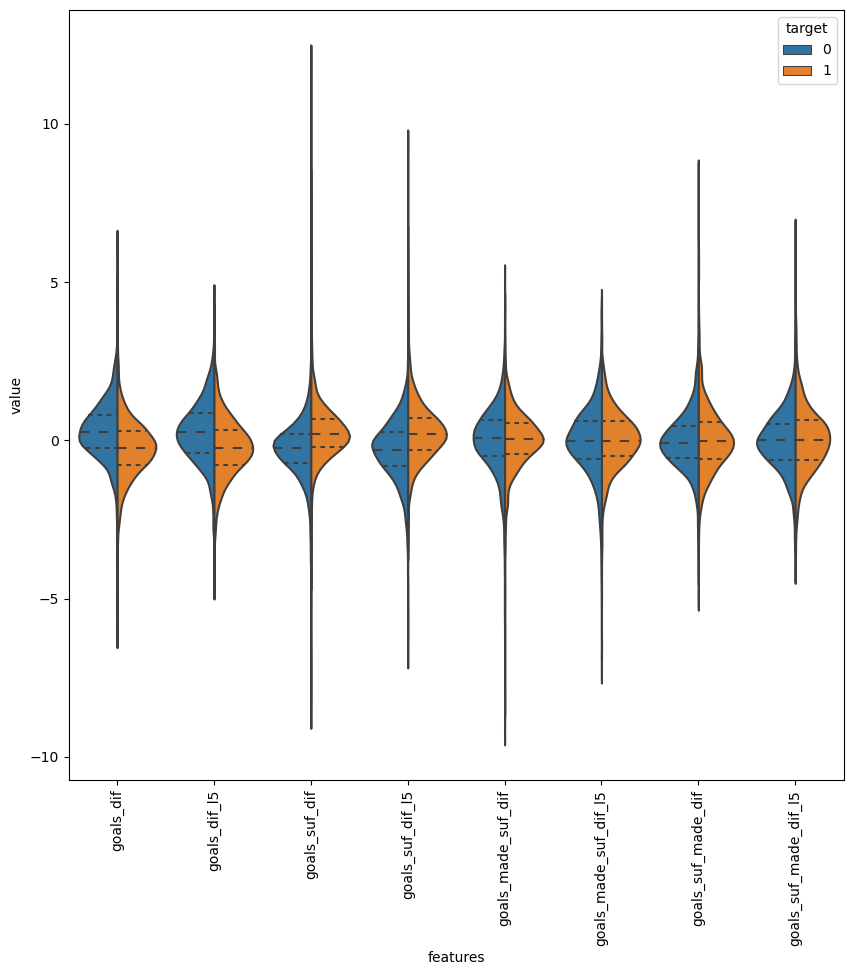

In [59]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Dengan plot itu, kita melihat bahwa perbedaan gol adalah pemisah yang baik, dan perbedaan tujuan juga terjadi. Perbedaan antara gol yang dibuat dan gol yang diderita tim bukanlah pemisah yang sangat baik.

Sekarang, kami memiliki 5 fitur:

rank_dif

gol_dif

gol_dif_l5

gol_suf_dif

gol_suf_dif_l5

Kita dapat membuat fitur lain, seperti perbedaan poin yang dibuat, perbedaan poin yang dibuat oleh peringkat yang dihadapi dan perbedaan peringkat yang dihadapi.

In [61]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [62]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Also, we can calculate goals made and suffered by rank, and check this difference.

In [63]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

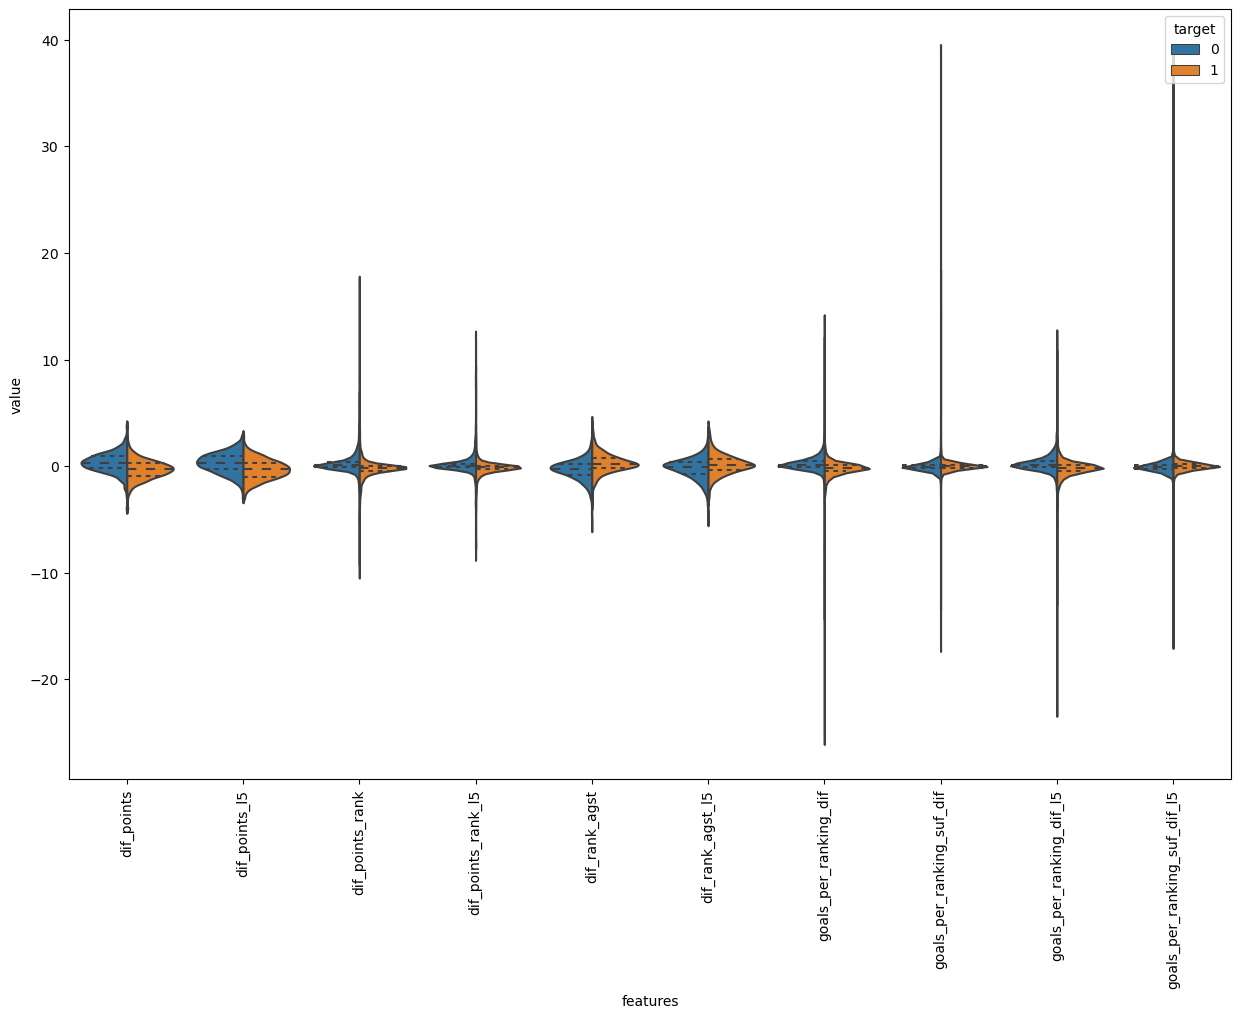

In [64]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Karena nilai yang rendah, plot biola bukanlah pilihan yang baik untuk menganalisis apakah fitur benar-benar memisahkan data dalam kasus ini. Kita akan melihat kemudian boxplot:

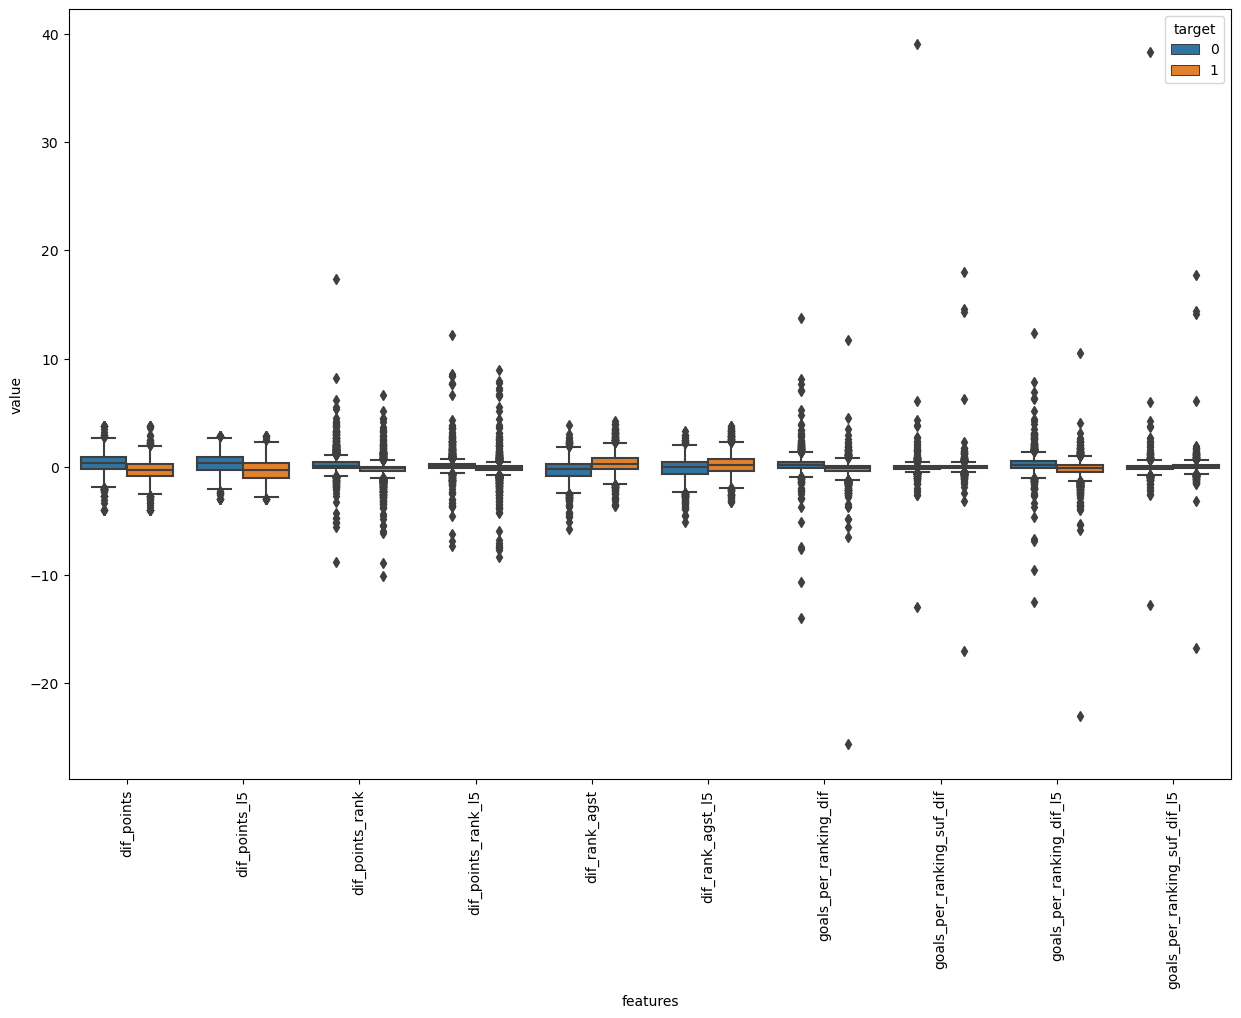

In [65]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

Selisih poin (pertandingan penuh dan 5 pertandingan terakhir), perbedaan poin berdasarkan peringkat yang dihadapi (pertandingan penuh dan 5 pertandingan terakhir) dan perbedaan peringkat yang dihadapi (pertandingan penuh dan 5 pertandingan terakhir) adalah fitur yang bagus. Selain itu, beberapa fitur yang dihasilkan memiliki distribusi yang sangat mirip yang akan dianalisis menggunakan scatterplot.

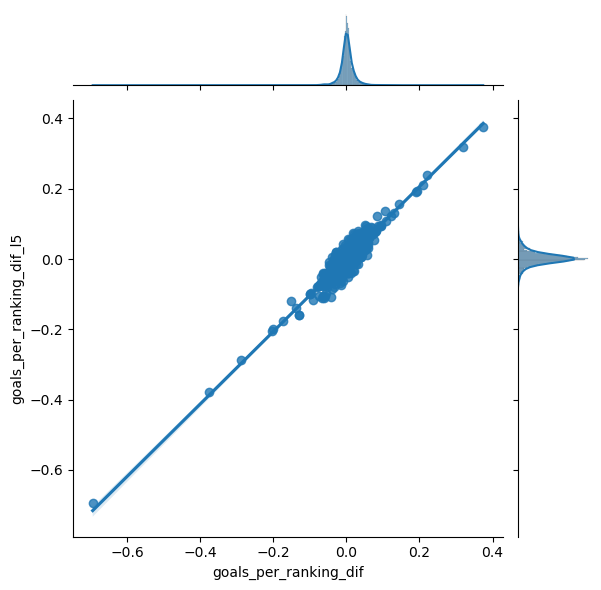

In [66]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

Selisih gol berdasarkan peringkat yang dihadapi dan versi 5 game terakhirnya memiliki distribusi yang sangat mirip. Jadi, kami hanya akan menggunakan versi lengkap (goals_per_ranking_dif).

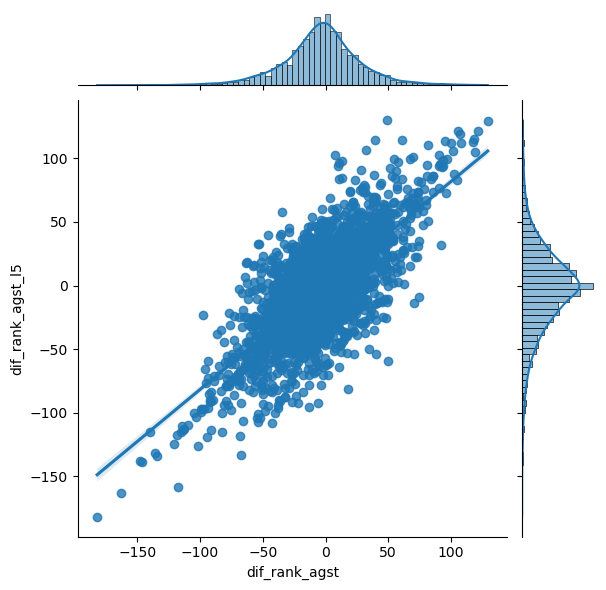

In [67]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

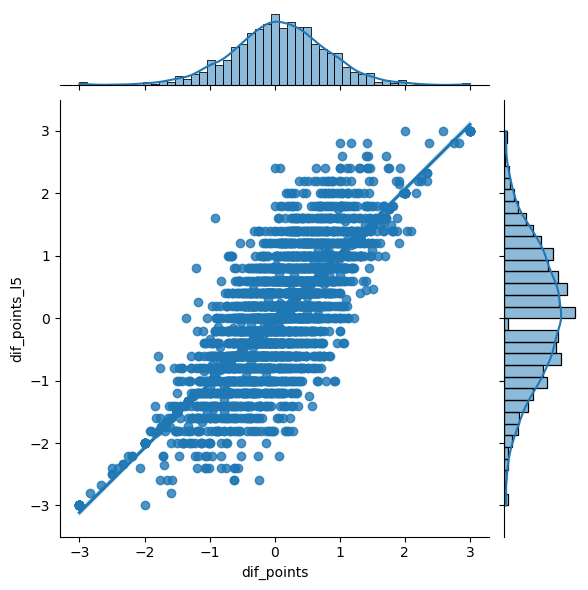

In [68]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

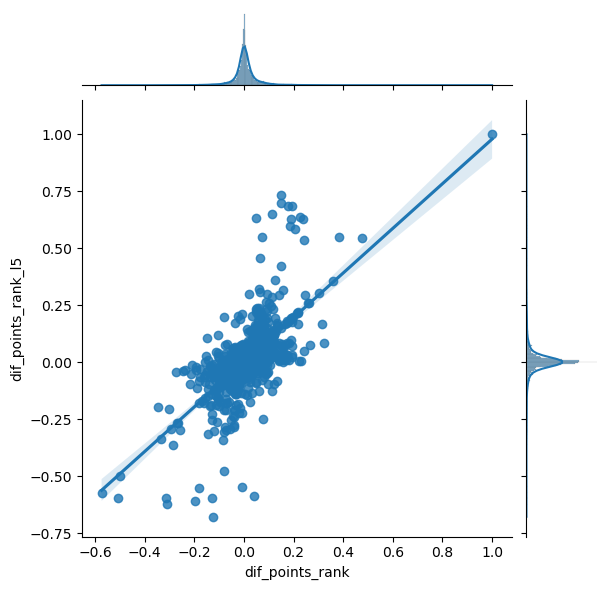

In [69]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

Untuk perbedaan peringkat, poin permainan berdasarkan peringkat dan rata-rata poin permainan berdasarkan peringkat , kedua versi (permainan lengkap dan 5) tidak begitu mirip. Jadi, kita akan menggunakan keduanya.

Berdasarkan itu, fitur akhir adalah:

rank_dif

gol_dif

gol_dif_l5

gol_suf_dif

gol_suf_dif_l5

dif_rank_agst

dif_rank_agst_l5

gol_per_rank_dif

dif_poin_rank

dif_poin_rank_l5

is_friendly

In [70]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [71]:
model_db = create_db(df)
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,Norway,Serbia,1,11.0,-0.038095,-0.8,-0.230159,0.0,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0
3335,Sweden,Slovenia,1,-45.0,0.030812,0.2,0.137255,0.2,0.009459,-25.102241,10.2,0.022485,-0.020314,1,0
3336,Kosovo,Cyprus,0,-2.0,0.667341,0.6,-0.463094,0.0,0.007625,7.037917,1.6,0.008791,-0.002827,1,0
3337,Greece,Northern Ireland,0,-9.0,0.067653,0.2,-0.369979,-1.2,-0.002915,16.024841,0.6,0.027775,0.018570,1,0


# Model

Sekarang kita memiliki database yang siap dan dengan kolom dengan kekuatan prediksi, kita dapat memulai pemodelan kita.

Dua model akan diuji: Random Forest dan Gradient Boosting. Yang terpilih akan menjadi yang memiliki daya ingat terbaik.

In [73]:
hblk

In [75]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [77]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [78]:
gb = gb_cv.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [79]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [80]:
rf = rf_cv.best_estimator_

In [81]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [82]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

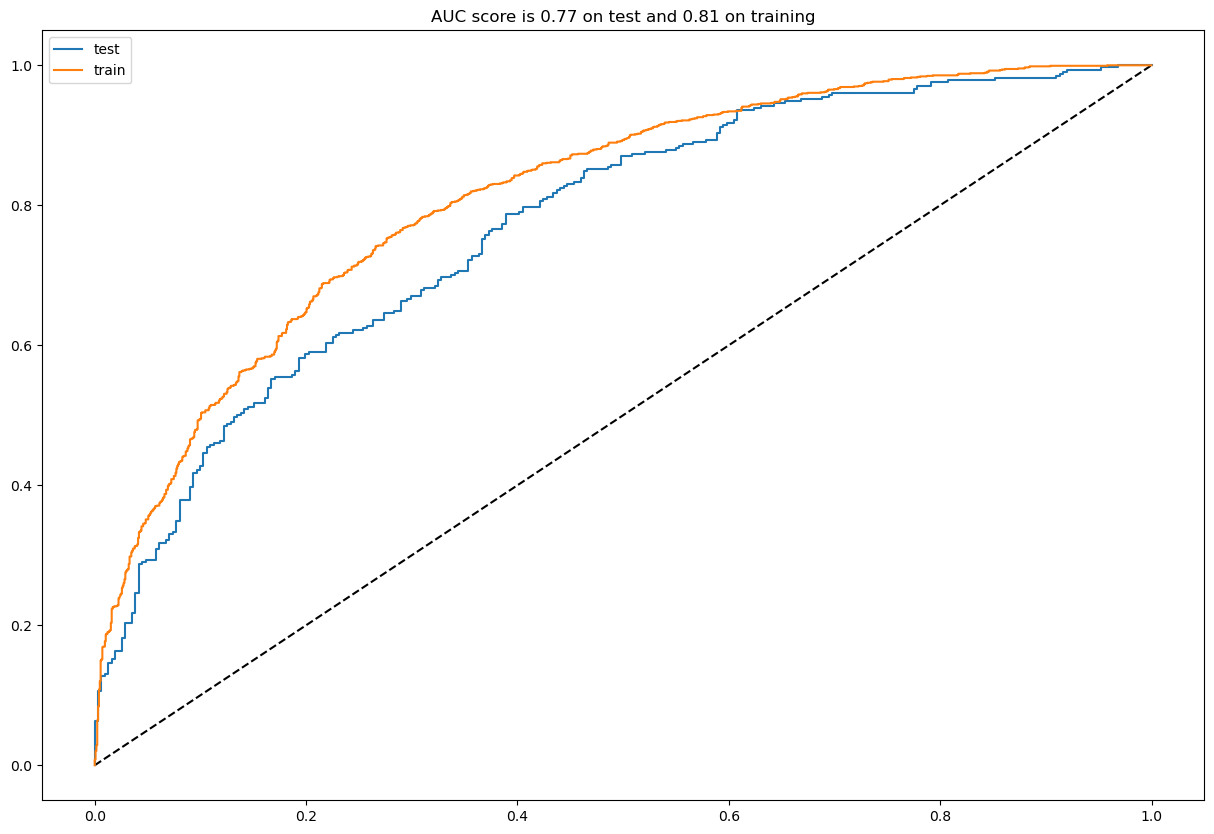

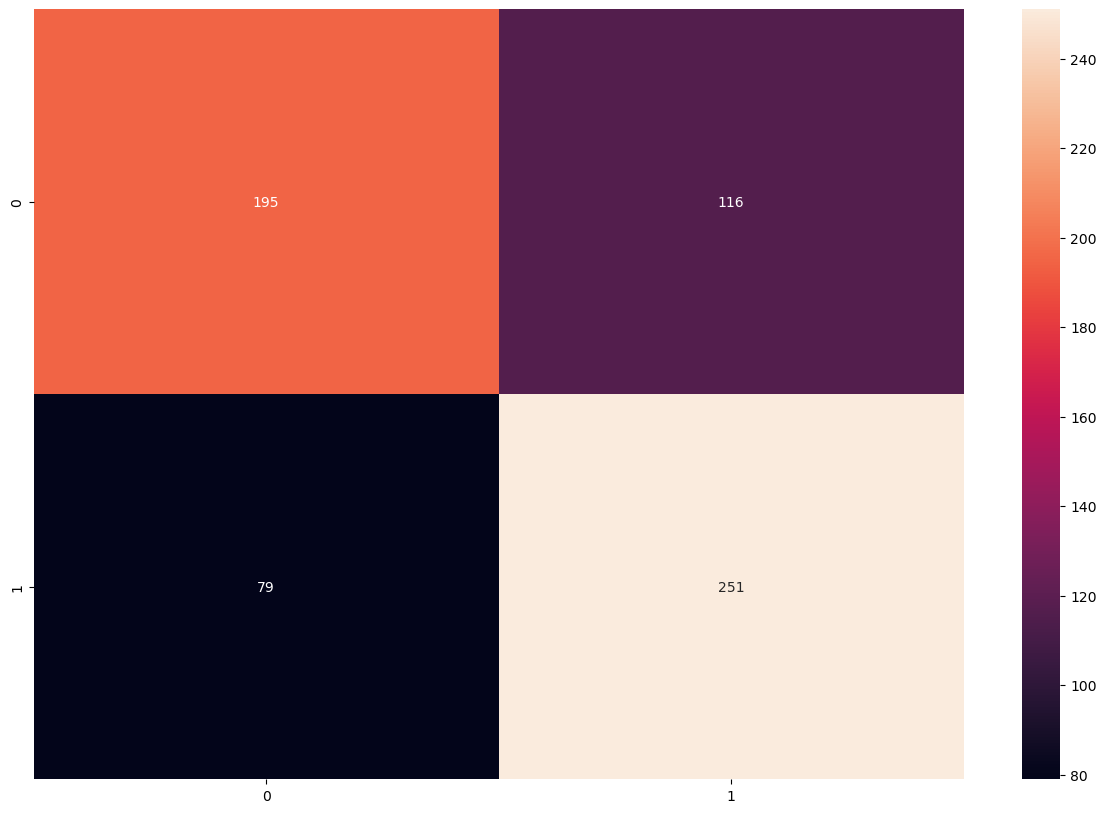

In [83]:
analyze(gb)

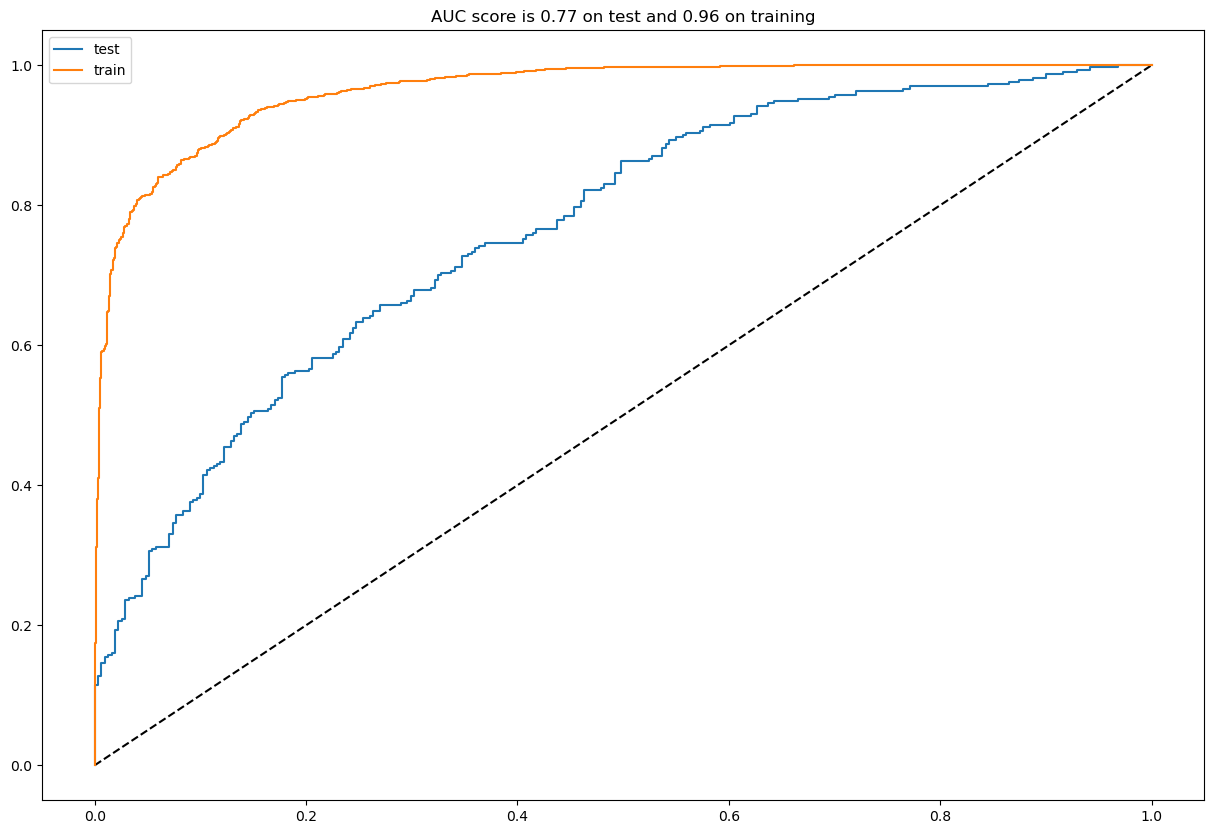

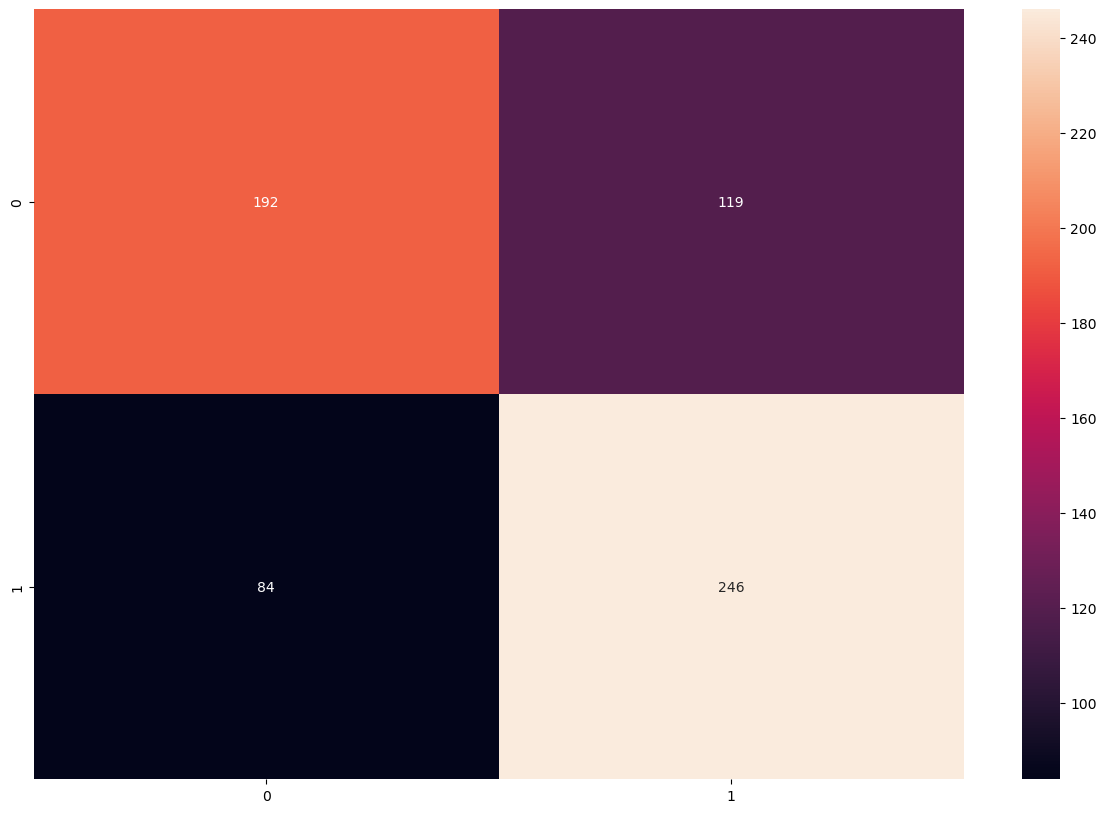

In [84]:
analyze(rf)

Model Random Forest sedikit lebih baik tetapi tampaknya kurang cocok. Jadi, kita akan menggunakan Gradient Boosting Model.

# Simulasi

In [106]:
table = {'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

import itertools as it
matches = []
for k in table:
    v = table[k]
    l = []
    for i in v:
        l.append(i[0])
    for e in it.combinations(l, 2):
        matches.append((k,e[0],e[1]))

In [107]:
table

{'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [108]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Qatar', 'Netherlands'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Ecuador', 'Netherlands'),
 ('A', 'Senegal', 'Netherlands'),
 ('B', 'England', 'Iran'),
 ('B', 'England', 'United States'),
 ('B', 'England', 'Wales'),
 ('B', 'Iran', 'United States')]

Saya akan menggunakan statistik pertandingan terakhir sebagai statistik untuk setiap tim yang terlibat dalam permainan. Seperti, untuk Brasil vs Serbia, statistik Brasil adalah yang mereka miliki di pertandingan terakhir dan juga untuk Serbia.

In [109]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [110]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Sekarang, kami dapat mensimulasikan.

Karena model mensimulasikan apakah tim 1 akan menang atau tidak, maka diperlukan beberapa kriteria untuk menentukan undian. Juga, karena kami tidak memiliki keunggulan tuan rumah di Piala Dunia, idenya adalah memprediksi permainan dua kali, mengubah tim 1 dan tim 2. Tim dengan rata-rata probabilitas tertinggi akan ditetapkan sebagai pemenang. Pada fase grup, jika "tim tuan rumah" menang sebagai tim 1 dan kalah sebagai tim 2, atau jika "tim tuan rumah" menang sebagai tim 2 dan kalah dari tim 1, akan ada hasil imbang dalam pertandingan tersebut.

In [113]:
from operator import itemgetter

advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.62 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.60 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.77 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.72 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.62 probability


Group A advanced: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.61 probability
Group B - England vs. United States: Winner England with 0.62 probability
Group B - England vs. Wales: Winner England with 0.65 probability
Group B - Iran vs. United States: Winner United States with 0.61 probability
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
England -------- 9
United

In [114]:
advanced = advanced_group

In [115]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [116]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.55
Argentina vs. Denmark: Argentina advances with prob 0.63
Spain vs. Croatia: Spain advances with prob 0.62
Brazil vs. Uruguay: Brazil advances with prob 0.65
Senegal vs. England: England advances with prob 0.63
Mexico vs. France: France advances with prob 0.62
Germany vs. Belgium: Belgium advances with prob 0.51
Switzerland vs. Portugal: Portugal advances with prob 0.55
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.50
Spain vs. Brazil: Brazil advances with prob 0.54
England vs. France: France advances with prob 0.51
Belgium vs. Portugal: Portugal advances with prob 0.54
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Brazil advances with prob 0.50
France vs. Portugal: Portugal advances with prob 0.53
----------
Starting simulation of Final
----------


Brazil 